<a href="https://colab.research.google.com/github/Davilirio/Python_data_analysis/blob/master/IBM_Regression_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas

from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [117]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge,RidgeCV, Lasso,LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import geopandas as gpd

import warnings
warnings.simplefilter("ignore")

plt.style.use('seaborn-dark')

In [31]:
data = pd.read_csv('/content/gdrive/MyDrive/data_science_stuff/datasets/rio_listings.csv')
data.shape

(26106, 74)

In [33]:
data.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 74, dtype: object

In [43]:
data = pd.read_csv('/content/gdrive/MyDrive/data_science_stuff/datasets/rio_listings.csv')
data['price'] = data['price'].str.replace('$','')
data['price'] = data['price'].str.replace(',','')
data['price'] = data['price'].str.replace(' ','')
data['price'] = data['price'].astype('float64')
data = data[data['price'].notna()]
data = data[data['bedrooms'].notna()]

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

data = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
data['price'] = data['price'].astype('float32')
data['price'].dropna(inplace=True)
data['bedrooms'].dropna(inplace=True)

In [44]:
data['price'].max()

1250.0

In [45]:
data.loc[data['price'] == data['price'].max()]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
3842,5205127,https://www.airbnb.com/rooms/5205127,20210126045954,2021-01-28,TRANQUILIDADE E CONFORTO,"Apartamento com sala em dois ambientes, 2 quar...","Bairro boêmio, com muitos bares, restaurantes ...",https://a0.muscache.com/pictures/65077663/78df...,26907475,https://www.airbnb.com/users/show/26907475,Angela,2015-01-29,"Rio de Janeiro, State of Rio de Janeiro, Brazil",Sou profissional liberal da área de Eventos.,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/26907475/prof...,https://a0.muscache.com/im/users/26907475/prof...,Santa Teresa,1.0,1.0,"['email', 'phone', 'manual_online', 'manual_of...",t,t,"Rio de Janeiro, Brazil",Santa Teresa,NaN,-22.91407,-43.19125,Entire house,Entire home/apt,4,NaN,1 bath,2.0,3.0,"[""Essentials"", ""Free parking on premises"", ""Ca...",1250.0,4,8,4,4,8,8,4.0,8.0,NaN,t,30,60,90,365,2021-01-28,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
4928,9225010,https://www.airbnb.com/rooms/9225010,20210126045954,2021-01-28,Refinement and Comfort at Corcovado,Next to the Corcovado Hill in the traditional ...,NaN,https://a0.muscache.com/pictures/6845d3a3-d5c6...,47963096,https://www.airbnb.com/users/show/47963096,Neri,2015-11-02,"Rio de Janeiro, State of Rio de Janeiro, Brazil","Trabalho com Moda, gosto de mesclar cores bási...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/94f59...,https://a0.muscache.com/im/pictures/user/94f59...,Laranjeiras,2.0,2.0,"['email', 'phone', 'reviews']",t,f,NaN,Laranjeiras,NaN,-22.93530,-43.18633,Entire apartment,Entire home/apt,7,NaN,3 baths,3.0,5.0,"[""Essentials"", ""Free parking on premises"", ""El...",1250.0,7,30,7,7,30,30,7.0,30.0,NaN,t,29,59,89,364,2021-01-28,1,0,0,2016-01-02,2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,1,0,0,0.02
4980,9345914,https://www.airbnb.com/rooms/9345914,20210126045954,2021-01-28,Suíte Maravilhosa!,"Suíte master, espaçosa, de frente para o mar ...","A praia, perto bons restaurantes e shoppings.",https://a0.muscache.com/pictures/216e10de-1721...,48504157,https://www.airbnb.com/users/show/48504157,Elisa,2015-11-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil","Chef de cozinha, adoro a natureza. Gosto de vi...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/9dd99...,https://a0.muscache.com/im/pictures/user/9dd99...,Barra da Tijuca,2.0,2.0,"['email', 'phone', 'reviews']",t,f,"Rio de Janeiro, Brazil",Barra da Tijuca,NaN,-23.01256,-43.31776,Private room in apartment,Private room,2,NaN,0 shared baths,1.0,1.0,"[""Free parking on premises"", ""Elevator"", ""Iron...",1250.0,2,1125,2,2,1125,1125,2.0,1125.0,NaN,t,30,60,90,365,2021-01-28,1,0,0,2017-09-15,2017-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,0,1,0,0.02
5921,10984938,http

## Main objective of the analysis that specifies whether your model will be focused on prediction or interpretation.

For this project, the aim is predicting prices of airbnb locations in NYC, based on the provided 2019 dataset of listing informations. A simple analysis will be conducted to look for visual information that may lead to better understanding and, for that reason, probably better model interpretation and results. The final output, although made by basic linear modelling, may be useful to help new airbnb listers to create their pricing through the predictive power of the model. 
- Linear Model: $ price = \beta_1feature_1 + \beta_2feature_2 + ... + 
\beta_nfeature_n + u$

The cost function may vary, due to our probable solutions being vanilla OLS, Ridge and Lasso 

- Vanilla Cost Function: $ \frac{\sum_{i=1}^n(y_{true} - y_{pred})^2}{n} $

- Ridge Cost Function:  - Vanilla Cost Function: $ \frac{\sum_{i=1}^n(y_{true} - y_{pred})^2}{n} + \lambda\sum_{i=1}^n\beta_n^2 $

- Lasso Cost Function:  - Vanilla Cost Function: $ \frac{\sum_{i=1}^n(y_{true} - y_{pred})^2}{n} + \lambda\sum_{i=1}^n|\beta_n| $

## Brief description of the data set you chose and a summary of its attributes.

In [46]:
data.shape, data.dtypes

((7028, 74), id                                                int64
 listing_url                                      object
 scrape_id                                         int64
 last_scraped                                     object
 name                                             object
                                                  ...   
 calculated_host_listings_count                    int64
 calculated_host_listings_count_entire_homes       int64
 calculated_host_listings_count_private_rooms      int64
 calculated_host_listings_count_shared_rooms       int64
 reviews_per_month                               float64
 Length: 74, dtype: object)

In [47]:
# numerical variable columns
cols = [col for col in data.columns if 'host' not in col]
data[cols].describe()

,id,scrape_id,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,reviews_per_month
count,7.028000e+03,7.028000e+03,0.0,7028.000000,7028.000000,7028.000000,0.0,7028.000000,6947.000000,7028.000000,7028.000000,7028.000000,7028.000000,7028.00000,7028.000000,7028.000000,7028.000000,7028.000000,0.0,7028.000000,7028.000000,7028.000000,7028.000000,7028.000000,7028.000000,7028.0,3020.000000,3017.0,3018.000000,3018.0,3020.0,3019.0,3020.000000,0.0,3341.000000
mean,2.510201e+07,2.021013e+13,NaN,-22.963371,-43.247481,3.507968,NaN,1.472396,2.070822,398.001129,2.816306,607.962863,2.786995,2.89428,712.198776,715.147268,2.814343,714.832584,NaN,19.212721,40.803216,63.466989,217.809192,2.402533,0.380194,0.0,98.666225,10.0,9.792578,10.0,10.0,10.0,9.649007,NaN,0.184122
std,1.514068e+07,1.746218e+00,NaN,0.029904,0.090632,1.728990,NaN,0.666724,1.255633,285.346100,1.729290,535.694375,1.720474,1.75780,522.236042,521.461063,1.721825,521.381536,NaN,12.795126,24.890130,36.151609,146.165372,4.321804,0.873215,0.0,2.673806,0.0,0.487889,0.0,0.0,0.0,0.590851,NaN,0.186042
min,6.479500e+04,2.021013e+13,NaN,-23.033740,-43.493880,1.000000,NaN,1.000000,0.000000,40.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,83.000000,10.0,8.000000,10.0,10.0,10.0,8.000000,NaN,0.010000
25%,1.298628e+07,2.021013e+13,NaN,-22.982990,-43.308735,2.000000,NaN,1.000000,1.000000,180.000000,1.000000,30.000000,1.000000,1.00000,30.000000,30.000000,1.000000,30.000000,NaN,1.000000,12.000000,27.750000,87.000000,0.000000,0.000000,0.0,98.000000,10.0,10.000000,10.0,10.0,10.0,9.000000,NaN,0.070000
50%,2.299684e+07,2.021013e+13,NaN,-22.967020,-43.198180,4.000000,NaN,1.000000,2.000000,300.000000,2.000000,1125.000000,2.000000,2.00000,1125.000000,1125.000000,2.000000,1125.000000,NaN,27.000000,57.000000,87.000000,260.000000,0.000000,0.000000,0.0,100.000000,10.0,10.000000,10.0,10.0,10.0,10.000000,NaN,0.120000
75%,4.063471e+07,2.021013e+13,NaN,-22.938268,-43.185790,4.000000,NaN,2.000000,3.000000,537.000000,4.000000,1125.000000,4.000000,4.00000,1125.000000,1125.000000,4.000000,1125.000000,NaN,30.000000,60.000000,89.000000,364.000000,3.000000,0.000000,0.0,100.000000,10.0,10.000000,10.0,10.0,10.0,10.000000,NaN,0.240000
max,4.789197e+07,2.021013e+13,NaN,-22.902220,-43.159220,12.000000,NaN,3.000000,6.000000,1250.000000,8.000000,1825.000000,7.000000,9.00000,1825.000000,1825.000000,7.700000,1825.000000,NaN,30.000000,60.000000,90.000000,365.000000,22.000000,5.000000,0.0,100.000000,10.0,10.000000,10.0,10.0,10.0,10.000000,NaN,1.700000


Note that good part of the variables are categorical

## Brief summary of data exploration and actions taken for data cleaning and feature engineering.

### Explorational Analysis

In [48]:
data['host_inf'] = data['host_about'].isna()

In [49]:
data.loc[data['host_inf'] == True]['price'].mean(), data.loc[data['host_inf'] == False]['price'].mean()

(417.1766357421875, 367.9382629394531)

In [50]:
count_df = data.groupby('neighbourhood_cleansed').count().sort_values('id', ascending=False)['id'].to_frame()
count_df.head()
count_df[:10]

,id
neighbourhood_cleansed,
Copacabana,1642
Barra da Tijuca,661
Ipanema,462
Jacarepaguá,460
Botafogo,411
Recreio dos Bandeirantes,330
Santa Teresa,301
Leblon,286
Tijuca,242


In [51]:
rio = gpd.read_file('/content/gdrive/MyDrive/data_science_stuff/datasets/geom_json/neighbourhoods.geojson')
rio.head()

,neighbourhood,neighbourhood_group,geometry
0,Paquetá,None,"MULTIPOLYGON Z (((-43.10567 -22.74888 0.00000,..."
1,Freguesia (Ilha),None,"MULTIPOLYGON Z (((-43.17170 -22.77661 0.00000,..."
2,Bancários,None,"MULTIPOLYGON Z (((-43.18915 -22.78318 0.00000,..."
3,Galeão,None,"MULTIPOLYGON Z (((-43.22804 -22.78374 0.00000,..."
4,Portuguesa,None,"MULTIPOLYGON Z (((-43.20763 -22.79498 0.00000,..."


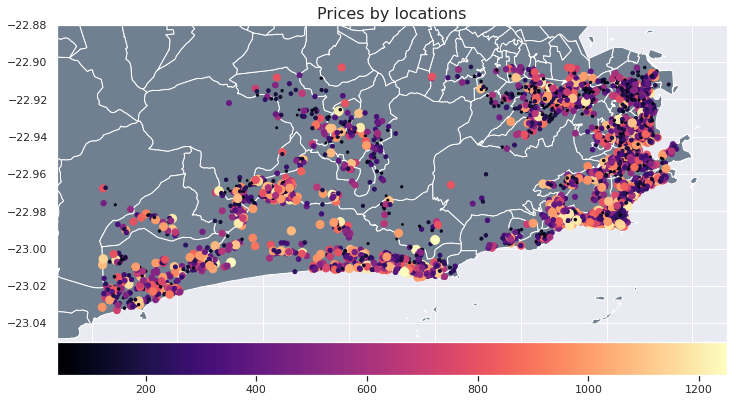

In [74]:
sns.set(font_scale = 1)

sns.color_palette("viridis", as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))

data_s = data.sample(5000)

rio.plot(column='neighbourhood', ax=ax,color='slategrey')

ax1=ax.scatter(data_s['longitude'], data_s['latitude'],s=data_s['price']/16,
           cmap=plt.get_cmap('magma'),c=data_s['price'])

ax.set_ylim((-23.05, -22.88))
ax.set_xlim((-43.52, -43.13))
ax.set_title('Prices by locations',size=16)

fig.colorbar(ax1, pad=0,orientation="horizontal")

Text(0.5, 1.0, 'Neighbourhoods with most listings')

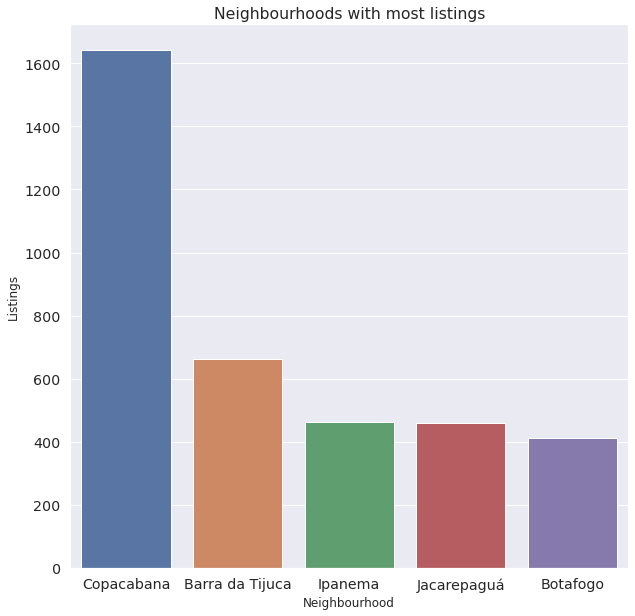

In [61]:
sns.set(font_scale = 1.3)

fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(data=count_df[:5], x=count_df[:5].index, y='id',ax=ax, )
ax.set_xlabel('Neighbourhood', size=12)
ax.set_ylabel('Listings', size=12)
ax.set_title('Neighbourhoods with most listings')

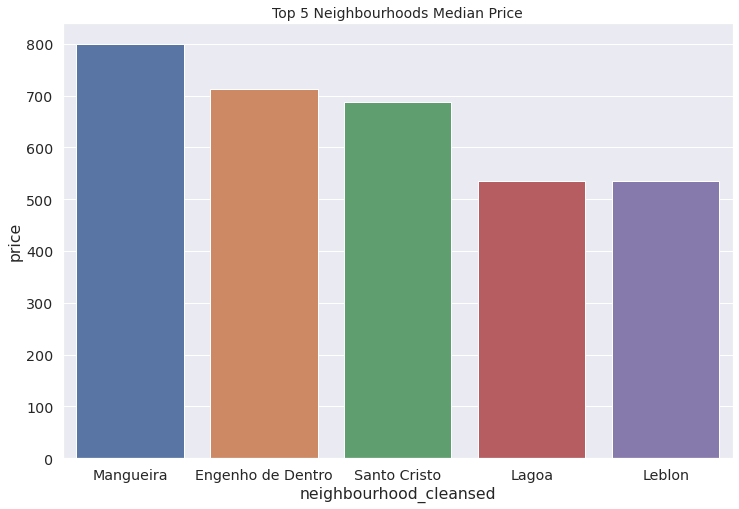

In [66]:
median_pr_5 =data.groupby('neighbourhood_cleansed').mean()['price'].to_frame()\
.sort_values('price',ascending=False).head().reset_index()

fig, ax = plt.subplots(figsize=(12,8))

sns.barplot(x='neighbourhood_cleansed',y='price',data=median_pr_5,ax=ax,)
ax.set_title('Top 5 Neighbourhoods Median Price',size=14);

In [55]:
data.loc[data['neighbourhood_cleansed']=='Mangueira']['price'].mean()

800.0

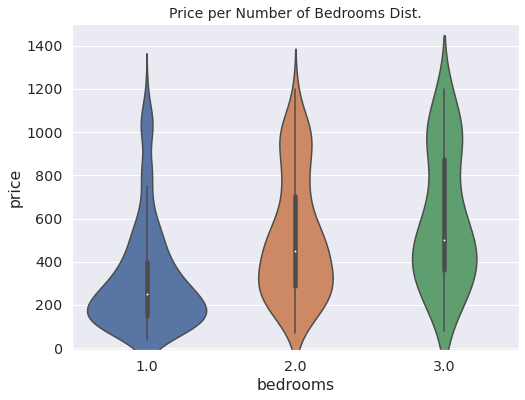

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.violinplot(x='bedrooms', y='price', data=data.sample(1000),ax=ax)

ax.set_title('Price per Number of Bedrooms Dist.',size=14)
ax.set_ylim((-10, 1500));

(-10.0, 1500.0)

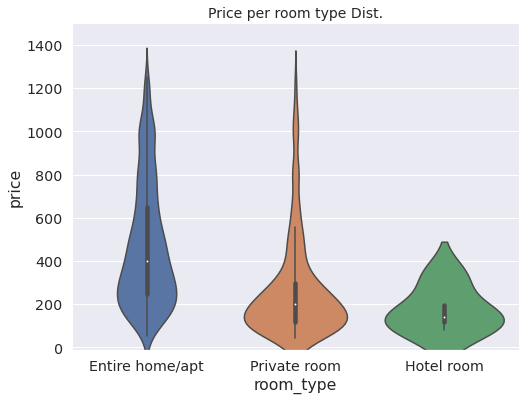

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.violinplot(x='room_type', y='price', data=data.sample(2000), ax=ax)
ax.set_title('Price per room type Dist.',size=14)
ax.set_ylim((-10, 1500))

In [175]:
top_50 = (data.groupby('neighbourhood')['id'].count()
                                             .sort_values(ascending = False)[:50])

df_50 = data.loc[data['neighbourhood'].isin(top_50.index.values)]

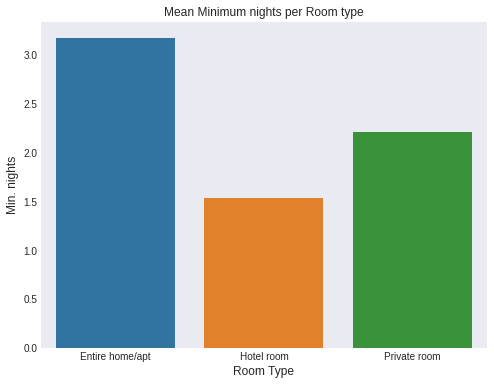

In [176]:
rm_mn = data.groupby('room_type')['minimum_nights'].mean().to_frame().reset_index()

fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(x = 'room_type',y='minimum_nights', data=rm_mn, ax=ax)
ax.set_xlabel('Room Type', size=12)
ax.set_ylabel('Min. nights', size=12)
ax.set_title('Mean Minimum nights per Room type');

In [178]:
br_pr = data.groupby('bedrooms')['price'].median().to_frame().dropna().reset_index()
br_pr

,bedrooms,price
0,1.0,240.0
1,2.0,450.0
2,3.0,600.0


In [194]:
# correlation bedrooms and price
br_pr.corr().values[0,1]

0.9954022744967959

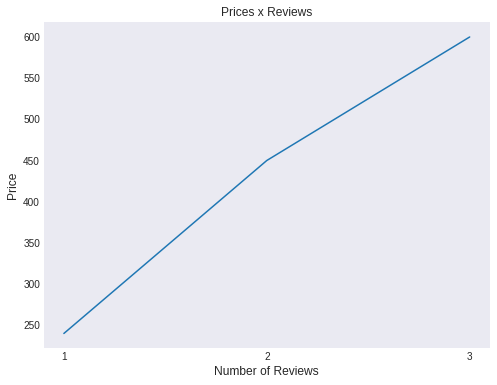

In [187]:
fig, ax = plt.subplots(figsize=(8,6))

sns.lineplot(br_pr['bedrooms'],
            br_pr['price'],ax=ax,)

ax.set_xlabel('Number of Reviews', size=12)
ax.set_xticks([1,2,3])
ax.set_ylabel('Price',size=12)
plt.title('Prices x Reviews')
plt.show()

### Feature Engineering

In [ ]:
# dropping unused columns
data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'log_price'],
      dtype='object')

In [27]:
# utility functions

def to_list(s):
  ls = list(s.split(','))
  return len(ls)

def rmse(true,pred): return np.sqrt(mean_squared_error(true,pred))

In [84]:
# dropping nans

data = pd.read_csv('/content/gdrive/MyDrive/data_science_stuff/datasets/rio_listings.csv')
data['price'] = data['price'].str.replace('$','')
data['price'] = data['price'].str.replace(',','')
data['price'] = data['price'].str.replace(' ','')
data['price'] = data['price'].astype('float64')

data = data[data['price'].notna()]
data = data[data['bedrooms'].notna()]
data = data[data['review_scores_rating'].notna()]                                

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

data = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
data['price'] = data['price'].astype('float32')
data['price'].dropna(inplace=True)
data['bedrooms'].dropna(inplace=True)
data['amenities'].fillna('0', inplace=True)
data['instant_bookable']=data['instant_bookable'].replace({'f':0, 't':1})

data = pd.concat([data,
                  pd.get_dummies(data['room_type'],
                                      prefix='r_t_')], axis=1)

data['nbr_amnts'] = data['amenities'].apply(to_list)
data['host_inf'] = data['host_about'].notna()

data.shape

(2803, 79)

In [85]:
data['host_inf'] = data['host_about'].notna()

## Linear Models

In [86]:
feature_cols = [x for x in data.columns if 'r_t_' in x]
feature_cols.append('bedrooms')
feature_cols.append('accommodates')
feature_cols.append('latitude')
feature_cols.append('longitude')
feature_cols.append('number_of_reviews')
feature_cols.append('review_scores_rating')
feature_cols.append('host_inf')
feature_cols.append('instant_bookable')
feature_cols.append('nbr_amnts')

In [87]:
feature_cols

['r_t__Entire home/apt',
 'r_t__Hotel room',
 'r_t__Private room',
 'bedrooms',
 'accommodates',
 'latitude',
 'longitude',
 'number_of_reviews',
 'review_scores_rating',
 'host_inf',
 'instant_bookable',
 'nbr_amnts']

In [101]:
pf = PolynomialFeatures(degree=2, include_bias=False,)
X = data[feature_cols]
X_pf  = pf.fit_transform(X)

Y = data['price']

x_train_pf, x_test_pf, y_train_pf, y_test_pf = train_test_split(X_pf, Y,
                                                                test_size=0.2,
                                                    random_state=7)

x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                                test_size=0.2,
                                                    random_state=7)

scaler = StandardScaler()

x_train_ssp = scaler.fit_transform(x_train_pf)
x_test_ssp = scaler.transform(x_test_pf)

x_train_ss = scaler.fit_transform(x_train)
x_test_ss = scaler.transform(x_test)

In [23]:
data['nbr_amnts'].mean()

19.970388869068856

In [14]:
x_train_ss.shape,x_test_ss.shape,

((2242, 90), (561, 90))

#### Non Scaled OLS

In [75]:
OLS = LinearRegression()

model_ns = OLS.fit(x_train,y_train)
not_scaled_coefs = model_ns.coef_

ols_pred = model_ns.predict(x_test)

nstd_r2 = r2_score(y_true=y_test, y_pred=model_ns.predict(x_test))

nstd_r2

0.41333531119724154

In [77]:
ols_nstd = rmse(y_test, ols_pred)
ols_nstd

128.65585322180314

#### Scaled OLS

In [26]:
model_ss = OLS.fit(x_train_ss, y_train)
scaled_coefs = model_ss.coef_

y_pred_ols_s = model_ss.predict(x_test_ss)

std_r2 = r2_score(y_true=y_test, y_pred=y_pred_ols_s)
std_r2

0.4134993829307404

In [78]:
ols_std = rmse(y_test, y_pred_ols_s)
ols_std

128.63786145807597

#### Scaled and PolyFactored Ridge

In [102]:
alphas = np.linspace(1e-4,45,100)

ridge = RidgeCV(alphas=alphas, 
                  cv=4).fit(x_train_ssp, y_train_pf)

y_pred_rr = ridge.predict(x_test_ssp)

r2_score(y_pred=y_pred_rr, y_true=y_test), ridge.alpha_

(0.4132197763500559, 12.727344444444444)

In [110]:
len(ridge.coef_),len([o for o in ridge.coef_ if o == 0])

(90, 3)

#### Scaled and PolyFactored Lasso

In [103]:
alphas2 = np.linspace(1e-5,2,100)

lasso = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(x_train_ssp, y_train_pf)
y_pred_ls = lasso.predict(x_test_ssp)

r2_score(y_pred=y_pred_ls, y_true=y_test), lasso.alpha_

(0.4132946594411614, 0.08081767676767676)

In [108]:
len(lasso.coef_),len([o for o in lasso.coef_ if o == 0])

(90, 47)

In [104]:
las_rmse = rmse(y_test,y_pred_ls)
rid_rmse = rmse(y_test, y_pred_rr)

las_rmse, rid_rmse

(128.66031061958444, 128.66852102240117)

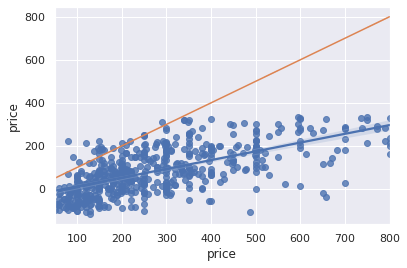

In [116]:
sns.regplot(y_test, y_pred_ols_s-200)
sns.lineplot(y_test,y_test)